In [77]:
import os
import math
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

In [78]:
DIMENSION = 10
QUERY_COUNT = 1000
ITEM_COUNT = 10 ** 6
GT_TOP_LEN=10000
RECALL_TOP_LEN = 5

MIN_EF_SEARCH = 10
MAX_EF_SEARCH = 10000
REGENERATE_DATA = False
HIDDEN_DIMENSIONS = list(range(8))
RECALL_OF_INTEREST = 0.95
N_SEARCH_THREADS = 8


In [32]:
build_graph_cmd_template = (
    "./RPG --mode base "
    "--baseSize 1000000 "
    "--trainQueries {featuresSize} "
    "--base data/synthetic/data/{features}.bin "
    "--outputGraph {graphPath} "
    "--relevanceVector {relevanceVector} "
    "--efConstruction 1000 --M 8 "
    "--metric {metric}"
)



In [33]:
search_cmd_template = (
    "./RPG --mode query --baseSize 1000000 --querySize 1000"
    " --query data/synthetic/data/model_scores/{scores} --inputGraph {inputGraph}"
    " --efSearch {efSearch} --topK {topK} --output data/synthetic/{searchResultFile}.txt" +
    " --gtQueries 1000 --gtTop {} ".format(GT_TOP_LEN) +
    "--groundtruth data/synthetic/data/model_scores/groundtruth_test.bin"
)

In [34]:
def normalize(a):
    vec_lengths = np.sqrt(np.power(a, 2).sum(axis=1, keepdims=True))
    return a / vec_lengths

def generate_or_read_data(file_name, shape):
    if not os.path.isfile(file_name):
        data = normalize(np.random.randn(*shape)).astype("float32")
        data.tofile(file_name)
    else:
        data = np.fromfile(file_name, dtype="float32").reshape(shape)
    return data

In [35]:
def sort_by(results, key):
    assert key in ["evals", "efSearch"]
    permutation = np.argsort(results[key])
    for key in results:
        vals = results[key]
        results[key] = [vals[i] for i in permutation]
    return results

assert sort_by({
    "efSearch": [2, 0, 3, 1],
    "vals": [1, 2, 3, 4]}, "efSearch") == {
    "efSearch": [0, 1, 2, 3],
    "vals": [2, 4, 1, 3]
}

In [36]:
def get_evals_for_recall(results, recall=RECALL_OF_INTEREST):
    results = sort_by(results, "evals")
    evals = results["evals"]
    recalls = results["recall"]
    ef_serch = results["efSearch"] if "efSearch" in results else evals
    assert len(evals) == len(recalls)
    
    lower_bound = 0
    lower_bound_ef = MIN_EF_SEARCH
    upper_bound = math.inf
    upper_bound_ef = MAX_EF_SEARCH
    
    if not evals:
        return lower_bound, upper_bound
    
    
    if recalls[0] <= recall:
        lower_bound = evals[0]
        lower_bound_ef = ef_serch[0]
        i = 1
        while i < len(evals) and recalls[i] <= recall:
            lower_bound = evals[i]
            lower_bound_ef = ef_serch[i]
            i += 1
    
    if recalls[-1] >= recall:
        upper_bound = evals[-1]
        upper_bound_ef = ef_serch[-1]
        i = len(evals) - 2
        while i >= 0 and recalls[i] >= recall:
            upper_bound = evals[i]
            upper_bound_ef = ef_serch[i]
            i -= 1
    
    return (lower_bound, upper_bound), (lower_bound_ef, upper_bound_ef)

assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.95, 0.96, 0.97]
}) == ((2, 2), (2, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.94, 0.955, 0.96, 0.97]
}) == ((1, 2), (1, 2))
assert get_evals_for_recall({
    "evals": [0, 1, 2, 3, 4],
    "recall": [0.93, 0.96, 0.94, 0.96, 0.97]
}) == ((0, 3), (0, 3))


In [37]:
def merge_results(lhs_res, rhs_res):
    assert not rhs_res or sorted(lhs_res.keys()) == sorted(rhs_res.keys())
    merged_res = {}
    for key in lhs_res:
        merged_res[key] = list(lhs_res[key]) + list(rhs_res[key])
    return merged_res


In [38]:
def logspace(start, stop, count, include_ends=True):
    cnt_ = count if include_ends else count + 2
    seq = np.exp(np.linspace(np.log(start), np.log(stop), cnt_))
    if include_ends:
        return seq
    return seq[1:-1]

In [40]:
def bench_cmd(cmd):
    res = {}
    with os.popen(cmd) as out:
        for line in out:
            for stat_name, prefix, suff_len in [
                ("relevance", "Average relevance: ", 1),
                ("recall", "Recall@5: ", 1),
                ("time", "Average query time: ", 3),
                ("evals", "Average number of model computations: ", 1)
            ]:
                if line.startswith(prefix):
                    res[stat_name] = float(line[len(prefix):-suff_len])
    return res

def run_search(graph_path, scores_file, topK=5, ef_ticks=EF_SEARCH_TICKS, result_file=None, n_threads=8):
    if result_file is None:
        result_file = "result.txt"
    else:
        assert len(ef_ticks) == 1
    
    commands = []
    for ef in ef_ticks:
        commands.append(search_cmd_template.format(
            scores=scores_file,
            inputGraph=graph_path,
            efSearch=ef,
            topK=topK,
            searchResultFile=result_file
        ))
    pool = Pool(processes=n_threads)
    results = pool.map(bench_cmd, commands)
    output = {"relevance": [], "recall": [], "time": [], "evals": []}
    for i, res in enumerate(results):
        if all(key in res for key in output):
            for key in output:
                output[key].append(res[key])
        else:
            print("missed result for {} efSearch {}.".format(graph, ef_ticks[i]))
    output["efSearch"] = list(ef_ticks)
    return output

In [43]:
def search_recall(graph_path, scores_file,
                  iterations=2, runs_per_iteration=None,
                  recall_of_interest=RECALL_OF_INTEREST, n_threads=8):
    if runs_per_iteration is None:
        runs_per_iteration = n_threads
    
    lower_ef_search_bound = MIN_EF_SEARCH
    upper_ef_search_bound = MAX_EF_SEARCH
    cur_results = {}
    for i in range(iterations):
        ef_ticks = logspace(lower_ef_search_bound, upper_ef_search_bound,
                            runs_per_iteration, include_ends=(i==0))
        result_update = run_search(graph_path, scores_file,
                                   ef_ticks=ef_ticks, n_threads=n_threads)
        cur_results = merge_results(result_update, cur_results)
        _, (lower_ef_search_bound, upper_ef_search_bound) = get_evals_for_recall(
            cur_results, recall=recall_of_interest)
    return sort_by(cur_results, "efSearch")

In [75]:
def read_txt(file_name, expected_shape=None):
    data = []
    with open(file_name) as fin:
        for line in fin:
            data.append([int(w) for w in line.split()])
    row_len = len(data[0])
    assert all(len(l) == row_len for l in data)
    if expected_shape is not None:
        assert expected_shape == (len(data), row_len)
    return data


def calc_eval_recall_curve(approximate_top, gt_top):
    assert gt_top.shape == (QUERY_COUNT, RECALL_TOP_LEN)
    
    gt_tops = [set(query_top) for query_top in gt_top]
    recalls = []
    found_count = 0
    top_len = len(approximate_top[0])
    for i in range(top_len):
        for query_id in range(QUERY_COUNT):
            if approximate_top[query_id][i] in gt_tops[query_id]:
                found_count += 1
        recalls.append(found_count / (QUERY_COUNT * RECALL_TOP_LEN))
    evals = list(range(1, top_len + 1))
    return {"evals": evals, "recall": recalls}
    

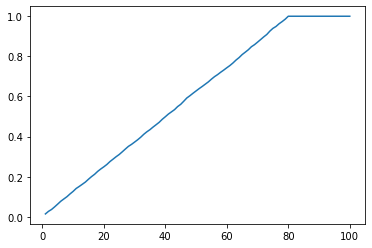

In [81]:
full_test_top = np.vstack([
    np.arange(100) for i in range(QUERY_COUNT)
])
test_gt = full_test_top[:,:RECALL_TOP_LEN]
approx_top = full_test_top.copy()
for row in approx_top:
    np.random.shuffle(row[:80])
test_curve = calc_eval_recall_curve(approx_top, test_gt)
plt.plot(test_curve["evals"], test_curve["recall"])


In [4]:
if REGENERATE_DATA:
    print("Generate synthetic queries and items") 
    train_queries = normalize(np.random.randn(QUERY_COUNT, DIMENSION)).astype("float32")
    train_queries.tofile("data/synthetic/data/train_queries.bin")

    test_queries = normalize(np.random.randn(QUERY_COUNT, DIMENSION)).astype("float32")
    test_queries.tofile("data/synthetic/data/test_queries.bin")
    
    items = normalize(np.random.randn(ITEM_COUNT, DIMENSION)).astype("float32")
    items.tofile("data/synthetic/data/items.bin")

    print("compute ground truth test scores")
    gt_train_scores = items.dot(train_queries.T)
    gt_train_scores.tofile("data/synthetic/data/model_scores/gt_train_scores.bin")
    del gt_train_scores

    gt_test_scores = items.dot(test_queries.T)
    gt_test_scores.tofile("data/synthetic/data/model_scores/gt_test_scores.bin")
    del gt_test_scores
    
    print("compute test scores for models with hidden dimensions") 
    for hidden_dim_count in HIDDEN_DIMENSIONS:
        hidden_model_test_scores = items[:,:-hidden_dim_count].dot(
            test_queries.T[:-hidden_dim_count]
        )
        hidden_model_test_scores.tofile(
            "data/synthetic/data/model_scores/hidden_{}_test_scores.bin".format(
                hidden_dim_count
            )
        )
        del hidden_model_test_scores

    print("Calc ground truth nearest neighbors")
    for data_part in ["train", "test"]:
        scores_path = "data/synthetic/data/model_scores/gt_{}_scores.bin".format(data_part)
        scores = np.fromfile(scores_path, dtype="float32").reshape(
            (ITEM_COUNT, QUERY_COUNT))
        gt = (-scores).argsort(axis=0)[:GT_TOP_LEN,:].T.astype("int32")
        gt.tofile("data/synthetic/data/model_scores/groundtruth_{}.bin".format(data_part))
        
    

In [82]:
experiment_results = {}
hidden_search_gt_evals = []
hidden_search_rerank_evals = []

In [7]:
for hidden_dim_count in HIDDEN_DIMENSIONS:
    graph_path = "data/synthetic/hidden_{}_of_{}_graph.out".format(
        hidden_dim_count, DIMENSION
    )
    if not os.path.isfile(graph_path) or REGENERATE_DATA:
        build_cmd = build_graph_cmd_template.format(
            featuresSize=DIMENSION,
            graphPath=graph_path,
            relevanceVector=DIMENSION - hidden_dim_count,
            features="items",
            metric="dot_product" # should be equivalent to l2
        )
        print(build_cmd)
        os.system(build_cmd)
    
    label = "hidden_{}_search_gt".format(hidden_dim_count)
    experiment_results[label] = search_recall(
        graph_path, "gt_test_scores.bin",
        iterations=3, n_threads=N_SEARCH_THREADS
    )
    (lower_evals, upper_evals), _ = get_evals_for_recall(experiment_results[label])
    hidden_search_gt_evals.append((lower_evals, upper_evals))
    
    label = "hidden_{}_search_rerank".format(hidden_dim_count)
    search_result_file = "search_result_hidden_{}".format(hidden_dim_count)
    run_search(
        graph_path,
        "hidden_{}_test_scores.bin".format(hidden_dim_count),
        topK=GT_TOP_LEN,
        ef_ticks=[1000],
        result_file=search_result_file
        n_threads=1
    )
    read_txt("data/synthetic/{}.txt".format(search_result_file), (QUERY_COUNT, GT_TOP_LEN))
    gt = np.fromfile()
    
    

./RPG --mode base --baseSize 1000000 --trainQueries 10 --base data/synthetic/data/items.bin --outputGraph data/synthetic/hidden_0_of_10_graph.out --relevanceVector 10 --efConstruction 1000 --M 8 --metric dot_product
./RPG --mode base --baseSize 1000000 --trainQueries 10 --base data/synthetic/data/items.bin --outputGraph data/synthetic/hidden_1_of_10_graph.out --relevanceVector 9 --efConstruction 1000 --M 8 --metric dot_product
./RPG --mode base --baseSize 1000000 --trainQueries 10 --base data/synthetic/data/items.bin --outputGraph data/synthetic/hidden_2_of_10_graph.out --relevanceVector 8 --efConstruction 1000 --M 8 --metric dot_product
./RPG --mode base --baseSize 1000000 --trainQueries 10 --base data/synthetic/data/items.bin --outputGraph data/synthetic/hidden_3_of_10_graph.out --relevanceVector 7 --efConstruction 1000 --M 8 --metric dot_product
./RPG --mode base --baseSize 1000000 --trainQueries 10 --base data/synthetic/data/items.bin --outputGraph data/synthetic/hidden_4_of_10_gra

In [46]:
def plot_results(results, x_data="evals", y_data="recall"):
    plt.xlabel(x_data)
    plt.ylabel(y_data)
#     plt.xlim([1000, 20000])
#     plt.ylim([0.8, 1])
    plt.xscale('log')
#     plt.yscale('log')
    for label, stats in results.items():
        plt.plot(stats[x_data], stats[y_data], label=label)
        plt.scatter(stats[x_data], stats[y_data], s=10)
    plt.legend()
    plt.show()



In [ ]:
plot_results(experiment_results)